## INITIALIZATION

In [1]:
%matplotlib notebook
import numpy as np
import time
import tables as tb
import matplotlib.pyplot as plt

from tjmonopix.tjmonopix import TJMonoPix
from tjmonopix.online_monitor import noise_monitor, plots
from tjmonopix.analysis import analysis_functions

import tjmonopix.scans.injection_scan

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml", no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45


2022-02-17 09:43:59,426 [INFO ] (MainThread) GPAC: power reset
2022-02-17 09:44:01,197 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-02-17 09:44:01,430 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-02-17 09:44:01,681 [INFO ] (MainThread) ibias = 45
2022-02-17 09:44:01,697 [INFO ] (MainThread) ibias = 503.125 nA
2022-02-17 09:44:02,266 [INFO ] (MainThread) {'VPC [V]': 1.2993515804695306, 'VDDA_DAC [mA]': 3.002966091804109, 'VDDP [V]': 1.8059798142570278, 'VDDP OC': False, 'VDDA [mA]': 49.64478938256647, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0527780625427745, 'VDDD OC': False, 'VPC [mA]': 0.12799944142567746, 'VPCSWSF [mA]': 0.060530040771719806, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10059447096451782}


## POWER STATUS

In [2]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'BiasSF [V]': 1.055278619399842,
 'BiasSF [mA]': 0.10109892318840588,
 'VDDA OC': False,
 'VDDA [V]': 1.8058565495495498,
 'VDDA [mA]': 49.64478938256647,
 'VDDA_DAC OC': False,
 'VDDA_DAC [V]': 1.8035484515484517,
 'VDDA_DAC [mA]': 3.002966091804109,
 'VDDD OC': False,
 'VDDD [V]': 1.8015140363636364,
 'VDDD [mA]': 2.820288999038665e-08,
 'VDDP OC': False,
 'VDDP [V]': 1.8059798142570278,
 'VDDP [mA]': 127.8936298255873,
 'VPC [V]': 1.2998506463536463,
 'VPC [mA]': 0.0144999414277582,
 'VPCSWSF [V]': 0.5001542395802099,
 'VPCSWSF [mA]': 0.14107000436903244}

In [ ]:
"""
# SELECT WHICH DOUBLE COLUMNS (PIXEL "FLAVOURS") TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(True)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['EN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE NORMAL HITOR PADS, HITOR0-3 =  1-4 flavor, ACTIVE LOW
chip['CONF_SR']['nEN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY HITOR PADS, ACTIVE LOW
chip.write_conf()

# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)

chip['CONF_SR']['INJ_IN_MON_L'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS LEFT SIDE
chip['CONF_SR']['INJ_IN_MON_R'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS RIGHT SIDE

# SELECT WHICH PHYSICAL ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][223:220] = True # FOR THE ANALOG MONITORING TOP PIXEL

# SELECT PHYSICAL COLUMNS AND ROWS FOR INJECTION WITH FUNCTION
#chip.enable_injection(3,18,99)
chip.write_conf()


# SELECT PHYSICAL COLUMN(S) FOR HITOR OUTPUT
# nMASKH (SO SETTING MASKH TO FALSE) ENABLES HITOR FOR THE SPECIFIC ROW
chip['CONF_SR']['DIG_MON_SEL'].setall(False)
#chip.enable_column_hitor(1,18)

chip.write_conf()
"""

## ANALOG FRONT END CONFIGURATION

In [3]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator. It is changed later.
ibias_dac = 100

## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-  
CAPCAL=20.3439450687
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-02-17 09:44:32,200 [INFO ] (MainThread) vl = 0.951929133858V
2022-02-17 09:44:32,232 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-17 09:44:32,253 [INFO ] (MainThread) vreset = 1.05106299213V
2022-02-17 09:44:32,269 [INFO ] (MainThread) icasn = 0
2022-02-17 09:44:32,286 [INFO ] (MainThread) icasn = 4.375 nA
2022-02-17 09:44:32,301 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-02-17 09:44:32,369 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-02-17 09:44:32,385 [INFO ] (MainThread) ithr = 5
2022-02-17 09:44:32,401 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-02-17 09:44:32,417 [INFO ] (MainThread) idb = 50
2022-02-17 09:44:32,433 [INFO ] (MainThread) idb = 892.5 nA
2022-02-17 09:44:32,447 [INFO ] (MainThread) ibias = 100
2022-02-17 09:44:32,470 [INFO ] (MainThread) ibias = 1104.6875 nA


## ENABLE MASK AND GET OCCUPANCY

In [4]:
th = 2
step = 50
dt = 0.2

noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
print("========= Getting residual occupancy =============")
pix_tmp, cnt = chip.get_occupancy(dt);

Enable MASKH 50
Got 58035 hits, total noisy pixels: 42
Enable MASKH 100
Got 116557 hits, total noisy pixels: 109
Enable MASKH 150
Got 34797 hits, total noisy pixels: 164
Enable MASKH 200
Got 182621 hits, total noisy pixels: 251
Enable MASKH 223
Got 44652 hits, total noisy pixels: 276
Enable MASKV 50
Got 7 hits, total noisy pixels: 278
Enable MASKV 100
Got 51 hits, total noisy pixels: 280
Enable MASKV 111
Got 68 hits, total noisy pixels: 282
Enable MASKD 50
Got 97 hits, total noisy pixels: 284
Enable MASKD 100
Got 3 hits, total noisy pixels: 284
Enable MASKD 150
Got 4 hits, total noisy pixels: 284
Enable MASKD 200
Got 4 hits, total noisy pixels: 285
Enable MASKD 250
Got 19 hits, total noisy pixels: 287
Enable MASKD 300
Got 13 hits, total noisy pixels: 288
Enable MASKD 350
Got 19 hits, total noisy pixels: 292
Enable MASKD 400
Got 92 hits, total noisy pixels: 295
Enable MASKD 447
Got 106 hits, total noisy pixels: 296
Checking again after masking
Got 18 hits, total noisy pixels: 299
Noisy 

# Configure injection and Select 1pixel 

2022-02-17 10:08:37,545 [INFO ] (MainThread) idb = 50
2022-02-17 10:08:37,561 [INFO ] (MainThread) idb = 892.5 nA
2022-02-17 10:08:37,575 [INFO ] (MainThread) vh = 1.80232283465V


('pixel (col and row) injected', 66, 10)
Got 183 hits in 0.2 s


<IPython.core.display.Javascript object>


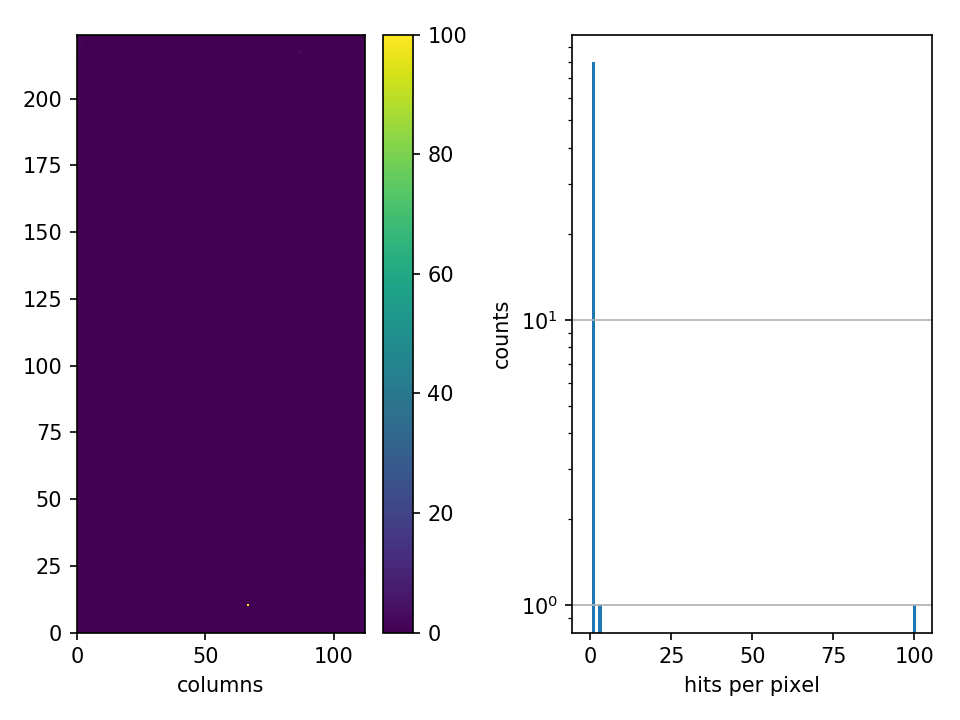

2022-02-17 10:08:39,977 [WARNI] (MainThread) Deprecated: Use get_FIFO_SIZE()


fifo size 1332
0 (66, 10) 100
1 (86, 217) 6
2 (6, 66) 2
3 (62, 26) 1
4 (49, 215) 1
5 (19, 52) 1
Wall time: 2.45 s


In [7]:
%%time
import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)

delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

idb = chip.set_idb_dacunits(50,1) #### threshold; SOPRA LA METTE CON 50 DAC
vh = chip.set_vh_dacunits(100,1) #### injection; SOPRA LA METTE CON 80 DAC
chip.write_conf()

col_to_inject = 66
row_to_inject = 10
chip.select_injection(col_to_inject, row_to_inject)

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)

chip.set_monoread()
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
chip["inj"].start()
while not chip['inj'].is_ready:
    time.sleep(0.001)
time.sleep(0.2)

print "fifo size", chip['fifo'].get_fifo_size()
ix = chip.interpret_data(chip['fifo'].get_data())
uni, cnt = np.unique(ix[["col","row"]], return_counts = True)
arg = np.argsort(cnt)
for a_i, a in enumerate(arg[::-1]):
    print a_i, uni[a], cnt[a]
    

## run parameter space scan using injection_scan

In [8]:
%%time
delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

idb = chip.set_idb_dacunits(20,1) 
vh = chip.set_vh_dacunits(80,1) # The functions below change vl w.r.t. vh
chip.write_conf()

scans = tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

collist = list(range(112))
rowlist = list(range(224))
injlist = np.arange(40, 0, -1)
thlist = [20] #list(range(20, 30))

output_filename = scans.start(
    collist = collist, rowlist = rowlist,
    injlist = injlist, thlist = thlist, phaselist = None,
    with_mon = False, n_mask_col = 5, debug = 4)


2022-02-17 10:08:56,664 [INFO ] (MainThread) idb = 20
2022-02-17 10:08:56,678 [INFO ] (MainThread) idb = 367.5 nA
2022-02-17 10:08:56,700 [INFO ] (MainThread) vh = 1.51885826772V
2022-02-17 10:08:56,700 [INFO ] (MainThread) Initializing InjectionScan
2022-02-17 10:08:59,693 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2993515804695306, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 79.53297889485958, 'VDDD [V]': 1.8005150383838384, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 143.50269488026495, 'BiasSF [V]': 1.0647807354566992, 'VDDD OC': False, 'VPC [mA]': 0.23149898547664347, 'VPCSWSF [mA]': -0.06753350383021829, 'VDDA [V]': 1.8038584294294295, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10059447096451782}
2022-02-17 10:09:14,007 [INFO ] (MainThread) Temperature (C): 30.096410
2022-02-17 10:09:14,145 [INFO ] (MainThread) Temperature (C): 29.

sleeping


2022-02-17 10:09:20,075 [WARNI] (MainThread) SRAM FIFO not empty after reset: size = 2651852
2022-02-17 10:09:48,960 [INFO ] (MainThread) Set timestamp: src=inj
2022-02-17 10:09:49,599 [INFO ] (MainThread) Starting FIFO readout
2022-02-17 10:09:49,631 [WARNI] (MainThread) SRAM FIFO not empty when starting FIFO readout: size = 728052


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('ro

('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:12:21,392 [INFO ] (MainThread) scan_param_id=0 dat=11554036: cols=[ 0 23 46 69 92]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:12:21,944 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:12:21,960 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 106)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 122)
('row', 122)

('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 138)
('row', 138)
('row', 138)

('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:14:53,473 [INFO ] (MainThread) scan_param_id=1 dat=-222334: cols=[ 1 24 47 70 93]


('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:14:54,006 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:14:54,020 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)

('row', 214)
('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-17 10:17:26,460 [INFO ] (MainThread) scan_param_id=2 dat=-481209: cols=[ 2 25 48 71 94]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:17:27,000 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:17:27,016 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)

('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-17 10:19:59,769 [INFO ] (MainThread) scan_param_id=3 dat=-31485: cols=[ 3 26 49 72 95]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:20:00,292 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:20:00,309 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:22:32,775 [INFO ] (MainThread) scan_param_id=4 dat=4626: cols=[ 4 27 50 73 96]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:22:33,308 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:22:33,322 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:25:05,361 [INFO ] (MainThread) scan_param_id=5 dat=-107358: cols=[ 5 28 51 74 97]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:25:05,894 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:25:05,910 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:27:38,134 [INFO ] (MainThread) scan_param_id=6 dat=-15279: cols=[ 6 29 52 75 98]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:27:38,667 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:27:38,683 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 17)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)

2022-02-17 10:30:11,437 [INFO ] (MainThread) scan_param_id=7 dat=-12960: cols=[ 7 30 53 76 99]


('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:30:11,996 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:30:12,012 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:32:44,171 [INFO ] (MainThread) scan_param_id=8 dat=167502: cols=[  8  31  54  77 100]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:32:44,710 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:32:44,724 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:35:16,332 [INFO ] (MainThread) scan_param_id=9 dat=-2868: cols=[  9  32  55  78 101]


('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:35:16,869 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:35:16,885 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:37:48,980 [INFO ] (MainThread) scan_param_id=10 dat=613521: cols=[ 10  33  56  79 102]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:37:49,513 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:37:49,529 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 17)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)

('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-17 10:40:21,723 [INFO ] (MainThread) scan_param_id=11 dat=-80799: cols=[ 11  34  57  80 103]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:40:22,266 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:40:22,282 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 17)
('row', 17)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)

('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)

('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)

('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-17 10:42:53,790 [INFO ] (MainThread) scan_param_id=12 dat=-839577: cols=[ 12  35  58  81 104]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:42:54,322 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:42:54,338 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 72)
('row', 72)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 106)
('row', 106)

('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:45:26,101 [INFO ] (MainThread) scan_param_id=13 dat=600: cols=[ 13  36  59  82 105]


('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:45:26,634 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:45:26,648 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 122)

('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 138)
('row', 138)
('row', 138)

('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:47:58,855 [INFO ] (MainThread) scan_param_id=14 dat=570282: cols=[ 14  37  60  83 106]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:47:59,388 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:47:59,404 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:50:32,217 [INFO ] (MainThread) scan_param_id=15 dat=-374532: cols=[ 15  38  61  84 107]


('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:50:32,752 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:50:32,772 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 106)
('row', 106)
('row', 106)
('row', 106)
('row', 106)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)
('row', 122)

('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 138)
('row', 138)
('row', 138)

('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 154)
('row', 154)

('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:53:04,563 [INFO ] (MainThread) scan_param_id=16 dat=-492741: cols=[ 16  39  62  85 108]


('row', 223)


2022-02-17 10:53:05,096 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:53:05,118 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('row', 72)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 106)

('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:55:37,566 [INFO ] (MainThread) scan_param_id=17 dat=164787: cols=[ 17  40  63  86 109]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 10:55:38,105 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:55:38,121 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('row', 89)
('ro

('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 106)
('row', 106)
('row', 106)
('row', 106)

('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 10:58:10,658 [INFO ] (MainThread) scan_param_id=18 dat=-16449: cols=[ 18  41  64  87 110]


('row', 223)
('row', 223)


2022-02-17 10:58:11,197 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 10:58:11,213 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 182)
('row', 182)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)

('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)

('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-17 11:00:44,299 [INFO ] (MainThread) scan_param_id=19 dat=220383: cols=[ 19  42  65  88 111]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 11:00:44,832 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 11:00:44,848 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)

2022-02-17 11:03:16,696 [INFO ] (MainThread) scan_param_id=20 dat=-1544118: cols=[20 43 66 89]


('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 11:03:17,227 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 11:03:17,243 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 89)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)
('row', 153)

('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)
('row', 169)

('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)
('row', 185)

('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)
('row', 201)

('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)
('row', 217)

2022-02-17 11:05:48,936 [INFO ] (MainThread) scan_param_id=21 dat=-22413: cols=[21 44 67 90]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 11:05:49,467 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 11:05:49,483 [INFO ] (MainThread) Starting FIFO readout


('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 0)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 1)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)
('row', 2)

('row', 17)
('row', 17)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 18)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 19)
('row', 20)
('ro

('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 35)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 36)
('row', 37)
('row', 37)
('row', 37)
('row', 37)
('ro

('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 52)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 53)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('row', 54)
('ro

('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 69)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 70)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('row', 71)
('ro

('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 86)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 87)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('row', 88)
('ro

('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 103)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 104)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)
('row', 105)

('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 119)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 120)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)
('row', 121)

('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 135)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 136)
('row', 137)
('row', 137)
('row', 137)
('row', 137)
('row', 137)

('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 151)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)
('row', 152)

('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 166)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 167)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)
('row', 168)

('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 182)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 183)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)
('row', 184)

('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 198)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 199)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)
('row', 200)

('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 214)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 215)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)
('row', 216)

2022-02-17 11:08:21,176 [INFO ] (MainThread) scan_param_id=22 dat=-29589: cols=[22 45 68 91]


('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)
('row', 223)


2022-02-17 11:08:21,709 [INFO ] (MainThread) Stopped FIFO readout
2022-02-17 11:08:21,723 [INFO ] (MainThread) g=None, dat=0
2022-02-17 11:08:21,740 [INFO ] (MainThread) Recived words: 9022026
2022-02-17 11:08:21,756 [INFO ] (MainThread) Data queue size: 0
2022-02-17 11:08:21,762 [INFO ] (MainThread) SRAM FIFO size: 0
2022-02-17 11:08:21,776 [INFO ] (MainThread) Channel:                     TDC | DATA_RX | TLU | TIMESTAMP
2022-02-17 11:08:21,792 [INFO ] (MainThread) Discard counter:             None |       0 |   0 |         0
2022-02-17 11:08:22,362 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2993515804695306, 'VDDA_DAC [mA]': 2.502471747485684, 'VDDP [V]': 1.8049802771084336, 'VDDP OC': False, 'VDDA [mA]': 78.51981992834118, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 129.40418450829804, 'BiasSF [V]': 1.063780512713872, 'VDDD OC': False, 'VPC [mA]': -0.4114981819124498, 'VPCSWSF [mA]': 

0 99999999 41.013% 4.567s 33333334hits 0errs
100000000 99999999 82.027% 9.577s 33333333hits 0errs
200000000 43822288 100.000% 10.793s 14607430hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2384830 MONO=7615170 MON=0


c:\users\belle2\tjmonopix-daq\tjmonopix\analysis\event_builder_inj.py:89: RuntimeWarning: overflow encountered in ubyte_scalars
  buf[buf_i]["tot"] = (dat[d_ii]["te"] - dat[d_ii]["le"]) & 0x3F


0 9999999 12.304% 230.721s 7386294hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2485733 MONO=7514267 MON=0
9999999 9999998 24.608% 463.731s 7513029hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2511372 MONO=7488628 MON=0
19999997 9999995 36.912% 695.026s 7488238hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2418594 MONO=7581406 MON=0
29999992 9999997 49.216% 928.349s 7480569hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2483503 MONO=7516497 MON=0
39999989 9999994 61.520% 1159.545s 7414017hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2501846 MONO=7498154 MON=0
49999983 9999999 73.824% 1390.368s 7338012hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2572519 MONO=7427481 MON=0
59999982 9999999 86.128% 1620.155s 7427297hits 0errs
data (inj_n 100,inj_loop 8960): INJ=2874107 MONO=7125893 MON=0
69999981 9999996 98.432% 1845.401s 7125723hits 0errs
data (inj_n 100,inj_loop 8960): INJ=375504 MONO=898616 MON=0
79999977 1274120 100.000% 1873.940s 898616hits 0errs
Wall time: 1h 32min 5s


Exception in thread TcpReadoutThread:
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda2\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "C:\ProgramData\Miniconda2\lib\threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "c:\users\belle2\basil\basil\TL\SiTcp.py", line 406, in _tcp_readout
    data = bytearray(self._sock_tcp.recv(1024 * 8))
error: [Errno 10054] Connessione in corso interrotta forzatamente dall'host remoto



In [ ]:
%%time
scans.analyze(output_filename)

<IPython.core.display.Javascript object>


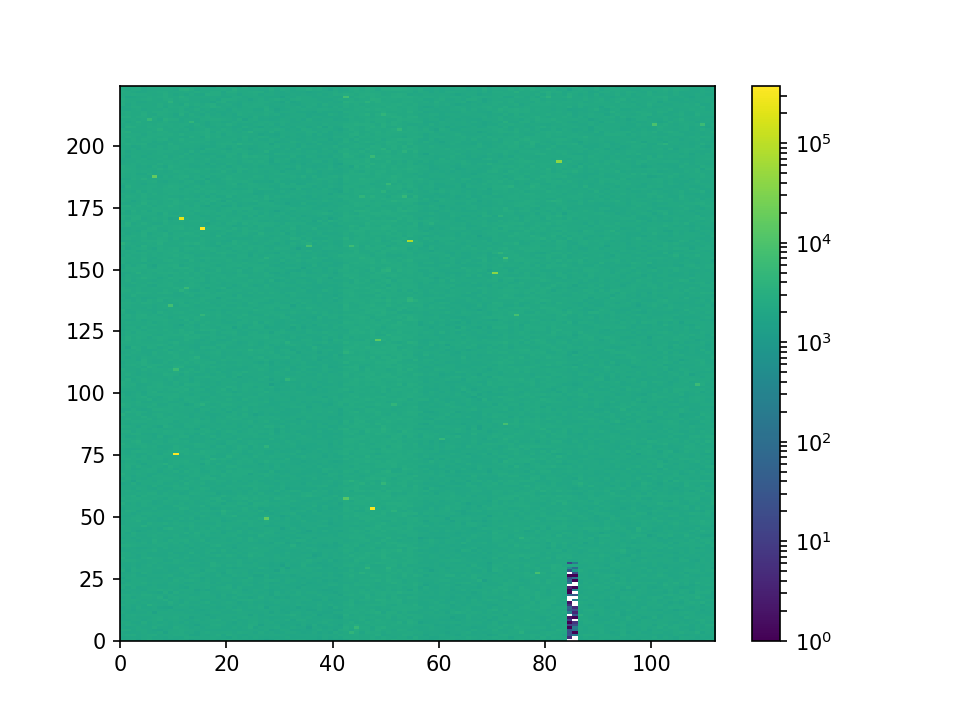

In [16]:
import tables
import matplotlib.colors
with tables.open_file(output_filename[:-len("scan.h5")]+"hit.h5") as f:
    plt.figure()
    plt.hist2d(f.root.Hits[:]["col"], f.root.Hits[:]["row"],
               bins=[112,224], range=[[0,112],[0,224]],
               norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.show()